<a href="https://colab.research.google.com/github/mmagavi/FinalProject1291/blob/main/SecondModel_FinalProjectCLPS1291.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project: Classifying Brain Tumors With Convolutional Neural Networks and Vision Transformer**

**Model:** Vision Transformer (ViT) \
**Source:** http://pytorch.org/vision/stable/models/vision_transformer.html

## **Importing the Data**


Importing the data from https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

**cjdata.label:** 1 for meningioma, 2 for glioma, 3 for pituitary tumor

**cjdata.PID:** patient ID

**cjdata.image:** image data

**cjdata.tumorBorder:** a vector storing the coordinates of discrete points on tumor border.

		For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
		It was generated by manually delineating the tumor border. So we can use it to generate
		binary image of tumor mask.

**cjdata.tumorMask:** a binary image with 1s indicating tumor region




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
# Importing and Downloading Images

!gdown 1p_q_wHJZQIEeinSUskvQHtqu88s2gfq8
!gdown 1EQRVW5M31GzZjEXnULygxpvBnIGOZ6WA
!gdown 1QxVOVJ89AHKQkbW-3Ftu-ajcDuzTTrIZ
!gdown 1A1dYyanURV6B7EPgI7VS-Y6tZuheEjJy
!unzip brainTumorDataPublic_22993064.zip -d tumor_data
!unzip brainTumorDataPublic_15332298.zip -d tumor_data
!unzip brainTumorDataPublic_7671532.zip -d tumor_data
!unzip brainTumorDataPublic_1766.zip -d tumor_data

Downloading...
From: https://drive.google.com/uc?id=1p_q_wHJZQIEeinSUskvQHtqu88s2gfq8
To: /content/brainTumorDataPublic_15332298.zip
100% 216M/216M [00:00<00:00, 268MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EQRVW5M31GzZjEXnULygxpvBnIGOZ6WA
To: /content/brainTumorDataPublic_22993064.zip
100% 232M/232M [00:02<00:00, 84.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QxVOVJ89AHKQkbW-3Ftu-ajcDuzTTrIZ
To: /content/brainTumorDataPublic_7671532.zip
100% 218M/218M [00:00<00:00, 238MB/s]
Downloading...
From: https://drive.google.com/uc?id=1A1dYyanURV6B7EPgI7VS-Y6tZuheEjJy
To: /content/brainTumorDataPublic_1766.zip
100% 214M/214M [00:01<00:00, 118MB/s] 
Archive:  brainTumorDataPublic_22993064.zip
  inflating: tumor_data/2299.mat     
  inflating: tumor_data/2300.mat     
  inflating: tumor_data/2301.mat     
  inflating: tumor_data/2302.mat     
  inflating: tumor_data/2303.mat     
  inflating: tumor_data/2304.mat     
  inflating: tumor_data/2305.mat     
  inflati

In [3]:
#!ls tumor_data # Checking Data was loaded correctly into folder.

# **Vision Transformer (ViT) Model**
Creating, Evaluating and Training a ViT Model on our data



**Setting Up**

- Downloading packages
- Setting up environment

In [4]:
%env CUDA_LAUNCH_BLOCKING=1 TORCH_USE_CUDA_DSA
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#SETUP
import time
import os
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]
plt.ion()
import cv2
import pickle
import numpy as np
from scipy.spatial.distance import pdist, squareform

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from torchsummary import summary
import json
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

env: CUDA_LAUNCH_BLOCKING=1 TORCH_USE_CUDA_DSA
Running on cuda:0


**Creating Model**

torchvision.models.vit_b_32()

In [5]:
vit = models.vit_b_16(weights="IMAGENET1K_V1")
vit = vit.to(device)
vit.eval()
#summary(vit, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 145MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [49]:
import h5py # Import Python Library to interact with HDF5 files

image_path = "tumor_data/1571.mat" # using one image to see model works

# Open the .mat file using h5py
with h5py.File(image_path, 'r') as file:
    label = file['cjdata']['label'][()][0, 0]
    patient_id = file['cjdata']['PID'][()][0, 0]
    image_data = file['cjdata']['image'][()]
    tumor_border = file['cjdata']['tumorBorder'][()].flatten() #make it into a 1D array of data on the border

In [7]:
# Similar code to assignment 7
# Preprocessing images

!gdown 13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj #imagenet_classes.json


def preprocess(image_data):
    data = np.repeat(image_data[..., np.newaxis], 3, -1)
    image = Image.fromarray((data * 255).astype(np.uint8))

    # Resize and normalize using PyTorch transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    normalized_image = transform(image)
    #print(normalized_image.shape)
    return normalized_image


PATH_TO_LABELS = 'imagenet_classes.json'
with open(PATH_TO_LABELS, 'r') as f:
    imagenet_classes = json.load(f)


def decode_preds(outputs, class_names=imagenet_classes):
  # Assuming outputs is the tensor of model outputs
  softmax_outputs = F.softmax(outputs, dim=1)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[str(idx)] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()

  # Print or return the results
  for label, score in zip(predicted_class_labels, probability_scores):
      print(f'\nClass: {label}, Probability: {score}')

Downloading...
From: https://drive.google.com/uc?id=13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj
To: /content/imagenet_classes.json
100% 32.6k/32.6k [00:00<00:00, 60.2MB/s]


Trying ViT before finetuning for our images

In [8]:
array = preprocess(image_data)

with torch.no_grad():
  vector = vit(array[None, :, :, :].cuda())


Class: cup, Probability: 0.21271488070487976


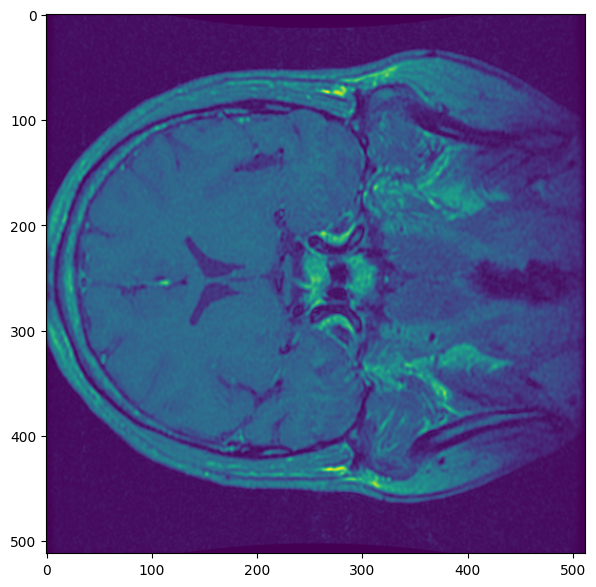

In [9]:
# Display the Image + Probability
plt.imshow(image_data)
decode_preds(vector)

**FineTuning the ViT Model**

In [10]:

from sklearn.model_selection import train_test_split
import shutil

# Create a Training, Testing, and Validation set

path = "tumor_data"
file_paths = [os.path.join(path, file) for file in os.listdir(path)]
train_files, test_val_files = train_test_split(file_paths, test_size=0.2, random_state=42)
test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

def move_files(file_list, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)
    for file in file_list:
        shutil.move(file, destination_folder)

# Move files to their folders
move_files(train_files, "tumor_data/train")
move_files(val_files, "tumor_data/validate")
move_files(test_files, "tumor_data/test")


In [11]:
class CustomMatDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.mat')]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]

        # Open the .mat file using h5py
        with h5py.File(file_path, 'r') as file:
            label = file['cjdata']['label'][()][0, 0]
            label = label - 1
            # patient_id = file['cjdata']['PID'][()][0, 0]
            image_data = file['cjdata']['image'][()]
            # tumor_border = file['cjdata']['tumorBorder'][()].flatten()

        if self.transform:
            image = self.transform(image_data)

        return image, label

train_dataset = CustomMatDataset(folder_path='tumor_data/train', transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomMatDataset(folder_path='tumor_data/test', transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

validate_dataset = CustomMatDataset(folder_path='tumor_data/validate', transform=preprocess)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=True)


Setting up the new labels for the new model

In [12]:
#class names
class_names = {
    0: "meningioma",
    1: "glioma",
    2: "pituitary tumor",
}

In [13]:
# Akash's code
standard_vit = models.vit_b_32(weights="IMAGENET1K_V1").to(device)

# Not! freezing the previous layers of the ViT (in order to finetune it)
for param in standard_vit.parameters():
    param.requires_grad = True

# Modify the model for 3-class classification of Brain images, Remove the fully connected layers (classifier) on top
standard_vit.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 3),  #3 classes of tumours
            nn.Softmax(dim=1) # Added
        )

# Now create a new model with the features of the standard VIT and a new classifier (fully connected layers)
class NewVIT(nn.Module):
    def __init__(self):
        super(NewVIT, self).__init__()
        self.oldvit = standard_vit

    def forward(self, x):
        x = self.oldvit(x)
        return x

new_vit = NewVIT()

#print(new_vit)

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:03<00:00, 115MB/s]


By this point we have added three layers to our vision transformer model, as well as creating a new classifier.

Now, we will train and test the updated model with our training and testing datasets that we defined above.

In [14]:
# Code adapted from: https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

from tqdm import tqdm, trange
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

**Training**

In [15]:
# Define Training Function
def train(model, epochs, lr, train_loader, validate_loader):

    # Training loop
    optimizer = Adam(model.parameters(), lr=lr)
    print(model.parameters())
    criterion = CrossEntropyLoss()
    accs= []

    for epoch in trange(epochs, desc="Training"):
        train_loss = 0.0

        #for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        for batch in train_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y = y.long()  # make into int64 long
            y_hat = model(x)
            loss = criterion(y_hat, y)


            train_loss += loss.detach().cpu().item() / len(train_loader)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
          val_acc = []
          for (batch_X, batch_y) in validate_loader:
            val_outputs = model(batch_X.cuda())
            val_loss = criterion(val_outputs, batch_y.long().cuda())

            # If y_val is one-hot encoded
            _, val_preds = torch.max(val_outputs, 1)
            # _, yv = torch.max(batch_y, 1)

            val_acc.append((val_preds == batch_y.cuda()).float().mean().item())
          accs.append(np.mean(val_acc))

        print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {np.mean(val_acc):.4f}")
        print(f"Epoch {epoch + 1}/{epochs} loss: {train_loss:.2f}")

    return accs

Testing the model with different epochs and learning rates:

<generator object Module.parameters at 0x79820bdf38b0>


Training:  10%|█         | 1/10 [00:59<08:56, 59.61s/it]

Validation Loss: 0.9616, Validation Accuracy: 0.4235
Epoch 1/10 loss: 1.51


Training:  20%|██        | 2/10 [01:58<07:54, 59.35s/it]

Validation Loss: 1.4893, Validation Accuracy: 0.4480
Epoch 2/10 loss: 1.09


Training:  30%|███       | 3/10 [02:58<06:55, 59.33s/it]

Validation Loss: 1.0272, Validation Accuracy: 0.5786
Epoch 3/10 loss: 0.96


Training:  40%|████      | 4/10 [03:57<05:56, 59.49s/it]

Validation Loss: 1.0448, Validation Accuracy: 0.6058
Epoch 4/10 loss: 0.92


Training:  50%|█████     | 5/10 [04:58<04:58, 59.79s/it]

Validation Loss: 1.1375, Validation Accuracy: 0.5692
Epoch 5/10 loss: 0.87


Training:  60%|██████    | 6/10 [05:57<03:58, 59.56s/it]

Validation Loss: 0.9224, Validation Accuracy: 0.5589
Epoch 6/10 loss: 0.94


Training:  70%|███████   | 7/10 [06:56<02:58, 59.50s/it]

Validation Loss: 1.0206, Validation Accuracy: 0.5296
Epoch 7/10 loss: 0.94


Training:  80%|████████  | 8/10 [07:55<01:58, 59.31s/it]

Validation Loss: 0.9092, Validation Accuracy: 0.4630
Epoch 8/10 loss: 0.91


Training:  90%|█████████ | 9/10 [08:54<00:59, 59.27s/it]

Validation Loss: 0.8622, Validation Accuracy: 0.5788
Epoch 9/10 loss: 0.89


Training: 100%|██████████| 10/10 [09:54<00:00, 59.45s/it]

Validation Loss: 1.0528, Validation Accuracy: 0.5505
Epoch 10/10 loss: 0.92


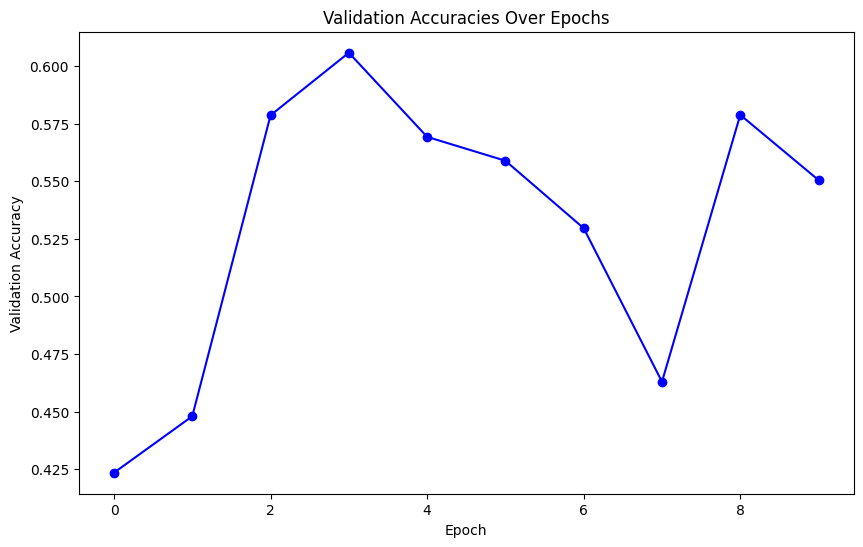

In [16]:
# 10 epochs, 0.01 lr
val2 = train(new_vit, 10, 0.01, train_loader, validate_loader)

# Plot the validation accuracy over time
plt.figure(figsize=(10,6))
plt.plot(val2, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies Over Epochs')
plt.show()

<generator object Module.parameters at 0x79820bbdd690>


Training:  10%|█         | 1/10 [00:59<08:53, 59.23s/it]

Validation Loss: 0.5907, Validation Accuracy: 0.7383
Epoch 1/10 loss: 0.70


Training:  20%|██        | 2/10 [01:57<07:50, 58.79s/it]

Validation Loss: 0.4200, Validation Accuracy: 0.7967
Epoch 2/10 loss: 0.63


Training:  30%|███       | 3/10 [02:57<06:55, 59.40s/it]

Validation Loss: 0.7341, Validation Accuracy: 0.7768
Epoch 3/10 loss: 0.57


Training:  40%|████      | 4/10 [03:56<05:53, 58.92s/it]

Validation Loss: 0.6598, Validation Accuracy: 0.7789
Epoch 4/10 loss: 0.54


Training:  50%|█████     | 5/10 [04:54<04:53, 58.64s/it]

Validation Loss: 0.4836, Validation Accuracy: 0.7852
Epoch 5/10 loss: 0.50


Training:  60%|██████    | 6/10 [05:52<03:54, 58.56s/it]

Validation Loss: 0.4372, Validation Accuracy: 0.8030
Epoch 6/10 loss: 0.53


Training:  70%|███████   | 7/10 [06:50<02:55, 58.49s/it]

Validation Loss: 0.5573, Validation Accuracy: 0.7737
Epoch 7/10 loss: 0.47


Training:  80%|████████  | 8/10 [07:49<01:56, 58.47s/it]

Validation Loss: 0.4376, Validation Accuracy: 0.8572
Epoch 8/10 loss: 0.50


Training:  90%|█████████ | 9/10 [08:47<00:58, 58.46s/it]

Validation Loss: 0.5333, Validation Accuracy: 0.8196
Epoch 9/10 loss: 0.51


Training: 100%|██████████| 10/10 [09:46<00:00, 58.63s/it]

Validation Loss: 0.5334, Validation Accuracy: 0.7727
Epoch 10/10 loss: 0.49


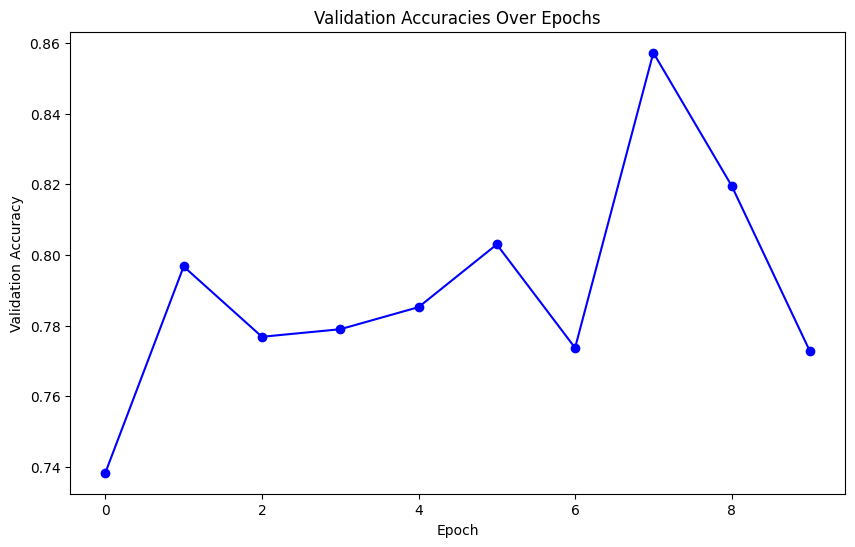

In [17]:
# 10 epochs, 0.001 lr
val3 = train(new_vit, 10, 0.001, train_loader, validate_loader)

# Plot the validation accuracy over time
plt.figure(figsize=(10,6))
plt.plot(val3, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies Over Epochs')
plt.show()

<generator object Module.parameters at 0x79820bbdd8c0>


Training:  10%|█         | 1/10 [00:59<08:56, 59.60s/it]

Validation Loss: 0.2940, Validation Accuracy: 0.8155
Epoch 1/10 loss: 0.41


Training:  20%|██        | 2/10 [02:08<08:40, 65.06s/it]

Validation Loss: 0.5304, Validation Accuracy: 0.8383
Epoch 2/10 loss: 0.39


Training:  30%|███       | 3/10 [03:12<07:30, 64.42s/it]

Validation Loss: 0.3723, Validation Accuracy: 0.8707
Epoch 3/10 loss: 0.38


Training:  40%|████      | 4/10 [04:12<06:16, 62.68s/it]

Validation Loss: 0.5568, Validation Accuracy: 0.8372
Epoch 4/10 loss: 0.37


Training:  50%|█████     | 5/10 [05:10<05:05, 61.08s/it]

Validation Loss: 0.2835, Validation Accuracy: 0.8447
Epoch 5/10 loss: 0.37


Training:  60%|██████    | 6/10 [06:08<04:00, 60.07s/it]

Validation Loss: 0.3309, Validation Accuracy: 0.8436
Epoch 6/10 loss: 0.37


Training:  70%|███████   | 7/10 [07:06<02:58, 59.34s/it]

Validation Loss: 0.1980, Validation Accuracy: 0.8697
Epoch 7/10 loss: 0.36


Training:  80%|████████  | 8/10 [08:05<01:58, 59.21s/it]

Validation Loss: 0.2094, Validation Accuracy: 0.8594
Epoch 8/10 loss: 0.36


Training:  90%|█████████ | 9/10 [09:03<00:58, 58.97s/it]

Validation Loss: 0.3187, Validation Accuracy: 0.8561
Epoch 9/10 loss: 0.35


Training: 100%|██████████| 10/10 [10:04<00:00, 60.47s/it]

Validation Loss: 0.4746, Validation Accuracy: 0.8539
Epoch 10/10 loss: 0.35


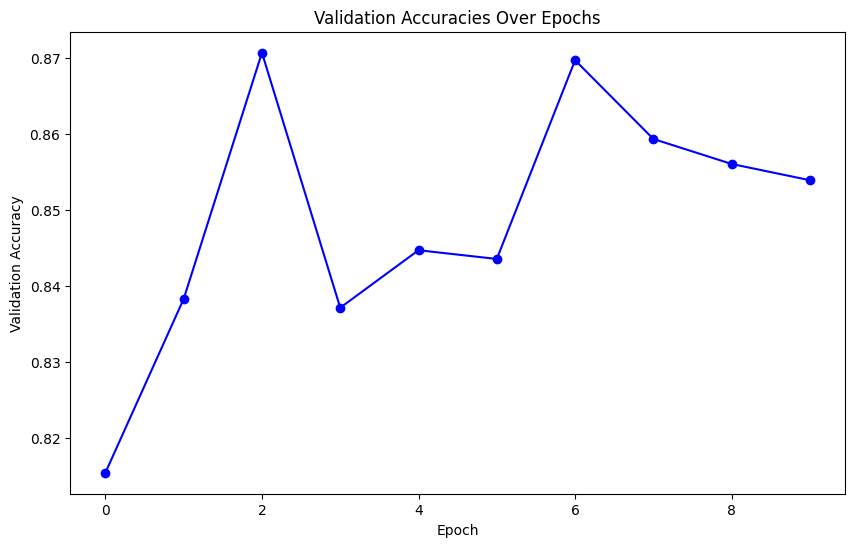

In [18]:
# 10 epochs, 0.0001 lr
val4 = train(new_vit, 10, 0.0001, train_loader, validate_loader)

# Plot the validation accuracy over time
plt.figure(figsize=(10,6))
plt.plot(val4, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies Over Epochs')
plt.show()

<generator object Module.parameters at 0x79820bbdcba0>


Training:   5%|▌         | 1/20 [00:59<18:42, 59.09s/it]

Validation Loss: 0.6289, Validation Accuracy: 0.8194
Epoch 1/20 loss: 0.42


Training:  10%|█         | 2/20 [01:58<17:48, 59.39s/it]

Validation Loss: 0.3960, Validation Accuracy: 0.8373
Epoch 2/20 loss: 0.44


Training:  15%|█▌        | 3/20 [02:58<16:51, 59.50s/it]

Validation Loss: 0.2329, Validation Accuracy: 0.8416
Epoch 3/20 loss: 0.41


Training:  20%|██        | 4/20 [03:59<16:01, 60.07s/it]

Validation Loss: 0.4126, Validation Accuracy: 0.8164
Epoch 4/20 loss: 0.41


Training:  25%|██▌       | 5/20 [04:59<15:01, 60.08s/it]

Validation Loss: 0.5853, Validation Accuracy: 0.8174
Epoch 5/20 loss: 0.40


Training:  30%|███       | 6/20 [05:57<13:53, 59.56s/it]

Validation Loss: 0.6006, Validation Accuracy: 0.8498
Epoch 6/20 loss: 0.40


Training:  35%|███▌      | 7/20 [06:57<12:52, 59.41s/it]

Validation Loss: 0.5872, Validation Accuracy: 0.8362
Epoch 7/20 loss: 0.39


Training:  40%|████      | 8/20 [07:56<11:54, 59.55s/it]

Validation Loss: 0.3797, Validation Accuracy: 0.8301
Epoch 8/20 loss: 0.39


Training:  45%|████▌     | 9/20 [08:55<10:52, 59.28s/it]

Validation Loss: 0.5658, Validation Accuracy: 0.8405
Epoch 9/20 loss: 0.37


Training:  50%|█████     | 10/20 [09:54<09:50, 59.07s/it]

Validation Loss: 0.2905, Validation Accuracy: 0.8436
Epoch 10/20 loss: 0.40


Training:  55%|█████▌    | 11/20 [10:52<08:49, 58.87s/it]

Validation Loss: 0.4447, Validation Accuracy: 0.8717
Epoch 11/20 loss: 0.43


Training:  60%|██████    | 12/20 [11:51<07:50, 58.78s/it]

Validation Loss: 0.2564, Validation Accuracy: 0.8635
Epoch 12/20 loss: 0.38


Training:  65%|██████▌   | 13/20 [12:49<06:51, 58.77s/it]

Validation Loss: 0.3221, Validation Accuracy: 0.7686
Epoch 13/20 loss: 0.36


Training:  70%|███████   | 14/20 [13:48<05:51, 58.66s/it]

Validation Loss: 0.5249, Validation Accuracy: 0.8133
Epoch 14/20 loss: 0.37


Training:  75%|███████▌  | 15/20 [14:46<04:52, 58.58s/it]

Validation Loss: 0.6125, Validation Accuracy: 0.8456
Epoch 15/20 loss: 0.40


Training:  80%|████████  | 16/20 [15:46<03:56, 59.09s/it]

Validation Loss: 0.2940, Validation Accuracy: 0.8613
Epoch 16/20 loss: 0.37


Training:  85%|████████▌ | 17/20 [16:45<02:57, 59.06s/it]

Validation Loss: 0.4812, Validation Accuracy: 0.7799
Epoch 17/20 loss: 0.39


Training:  90%|█████████ | 18/20 [17:44<01:57, 58.88s/it]

Validation Loss: 0.5828, Validation Accuracy: 0.8102
Epoch 18/20 loss: 0.41


Training:  95%|█████████▌| 19/20 [18:43<00:58, 58.87s/it]

Validation Loss: 0.6398, Validation Accuracy: 0.8340
Epoch 19/20 loss: 0.41


Training: 100%|██████████| 20/20 [19:41<00:00, 59.10s/it]

Validation Loss: 0.5674, Validation Accuracy: 0.7414
Epoch 20/20 loss: 0.48


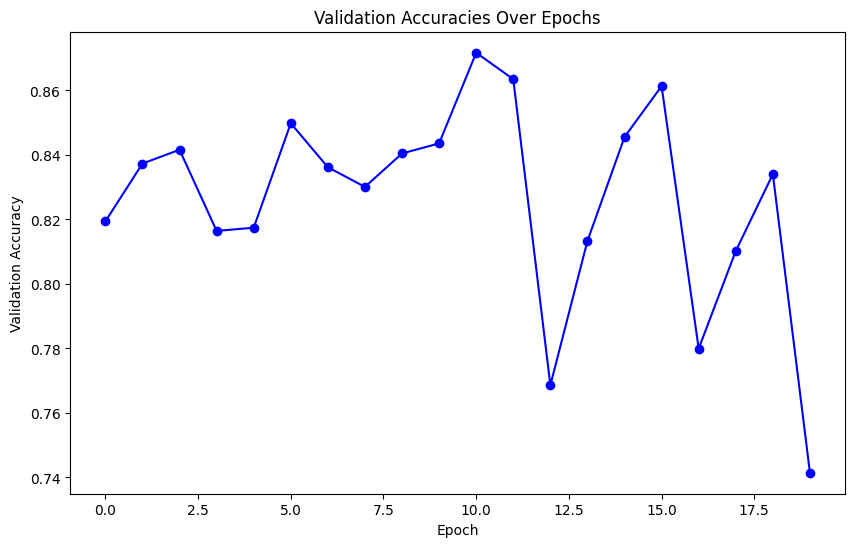

In [19]:
# 20 epochs, 0.001 lr
val = train(new_vit, 20, 0.001, train_loader, validate_loader)

# Plot the validation accuracy over time
plt.figure(figsize=(10,6))
plt.plot(val, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies Over Epochs')
plt.show()

**Testing** (for 20 epochs and 0.001, the last trained model)

In [20]:
# Define Test function
def test(model, test_loader):

    criterion = CrossEntropyLoss()

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y = y.long()  # make into int64 long
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")


In [21]:
# Call Testing Function
test(new_vit, test_loader)

Testing: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]

Test loss: 0.58
Test accuracy: 76.80%


In [22]:
# New decode preds for brain data

def decode_brain_preds(outputs, class_names=class_names):
  # Assuming outputs is the tensor of model outputs
  softmax_outputs = F.softmax(outputs, dim=1)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[idx] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()

  # Print or return the results
  for label, score in zip(predicted_class_labels, probability_scores):
      print(f'\nClass: {label}, Probability: {score}')
  return predicted_class.item()



Class: pituitary tumor, Probability: 0.717309296131134
3.0


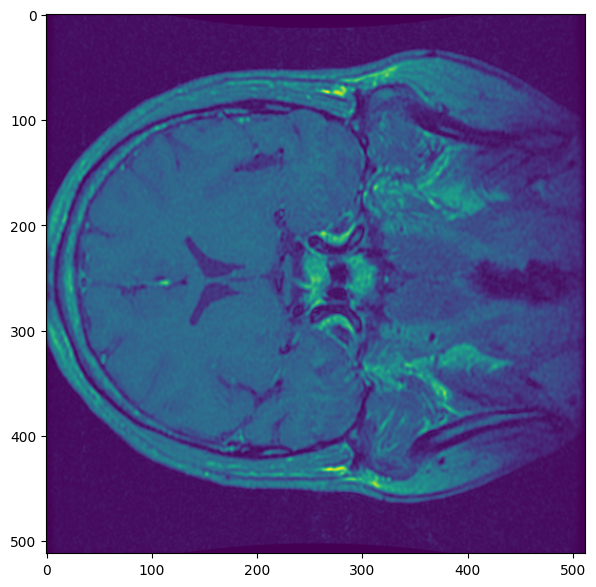

In [23]:
# Checking classification
array = preprocess(image_data)

with torch.no_grad():
  vector = new_vit(array[None, :, :, :].cuda())

# Display the image

plt.imshow(image_data) #coloured by plt.imshow()
decode_brain_preds(vector)
print(label) #to check the correct version

# **Interpretability**
Assessing the interpretablity of our model by displaying the saliency maps for random images.

***Download and import packages we need to run the code.***

In [24]:
!pip install torchvision==0.13.0
!pip install git+https://github.com/pytorch/captum.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu121
    Uninstalling torchvision-0.16.0+cu121:
      Successfully uninstalled torchvision-0.16.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.


  Cloning https://github.com/pytorch/captum.git to /tmp/pip-req-build-3pa_g4uz
  Running command git clone --filter=blob:none --quiet https://github.com/pytorch/captum.git /tmp/pip-req-build-3pa_g4uz
  Resolved https://github.com/pytorch/captum.git to commit 68d88cf6bec6a0bf73575d2d7be1b2506fdce61c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for captum: filename=captum-0.7.0-py3-none-any.whl size=637238 sha256=b93d1a3d56e2645acb21be2bfb8e6bb3dad2fd6cd51b5bf36071c5b967e86bf2
  Stored in directory: /tmp/pip-ephem-wheel-cache-lzxdfify/wheels/8e/b7/c3/e17a61e561b99ab720ae04e56543dcd69884dee09a09bf5ae4
Successfully built captum


In [25]:
# Import captum
import captum
from captum.attr import visualization as viz
from torchvision import transforms

***Interpretability on the same random image we chose at the start of the code.***

In [26]:
new_vit.eval()

NewVIT(
  (oldvit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNo

In [27]:
image = preprocess(image_data).to(device)
image - image.unsqueeze_(0) #preprocessed image
saliency = captum.attr.Saliency(new_vit)
attributions = saliency.attribute(image, target=0) #the attributions obtained from captum

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


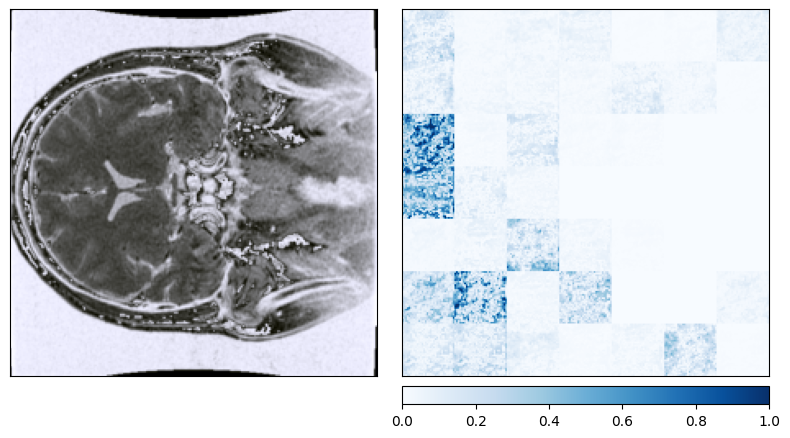

In [28]:
# The preprocessing included normalizing the image which we need invert here
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

# Your input image to the model.
unnorm_image = inv_normalize(image)

# Display the image and the attribution
_ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(unnorm_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=None,
                                      show_colorbar=True, outlier_perc=2)

***Interpretability on 10 random images.***

We did this by:
*  Opening 10 random images from their filepaths with h5py.
*   Preprocessing and decoding them.
*   Displaying the original image alongside predicted label and it's probability.
* Displaying the saliency map.



In [41]:
# Checking what files got randomly assigned to each cagtegory, get the 10 random image filepaths.
# ls tumor_data/train
# ls tumor_data/test
# ls tumor_data/validate


Class: meningioma, Probability: 0.6626770496368408


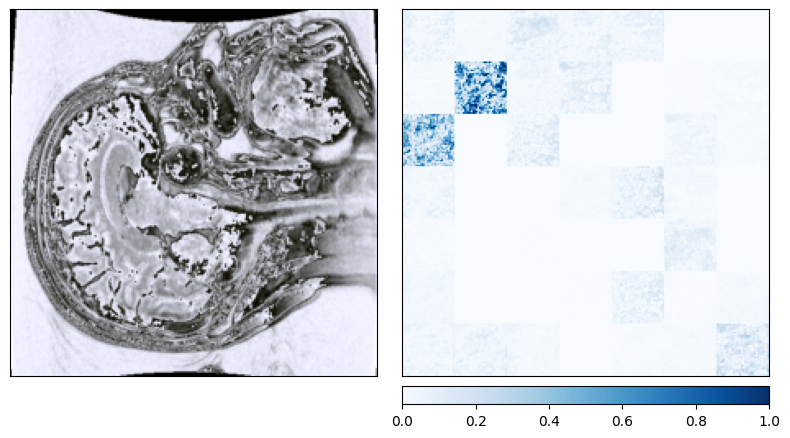


Class: meningioma, Probability: 0.6972644329071045


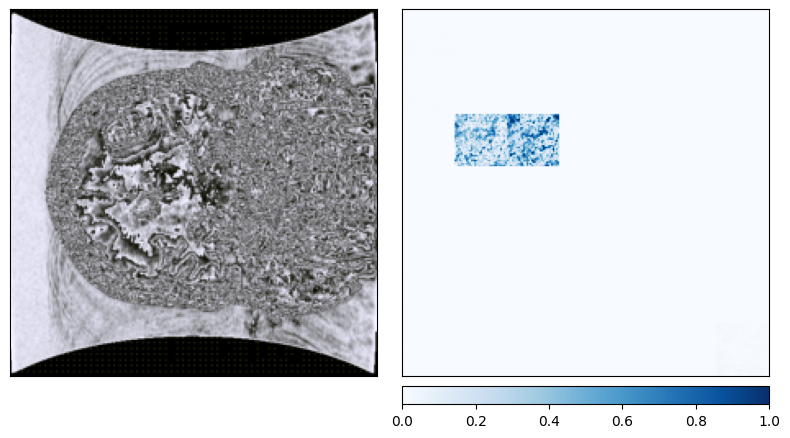


Class: glioma, Probability: 0.5147355198860168


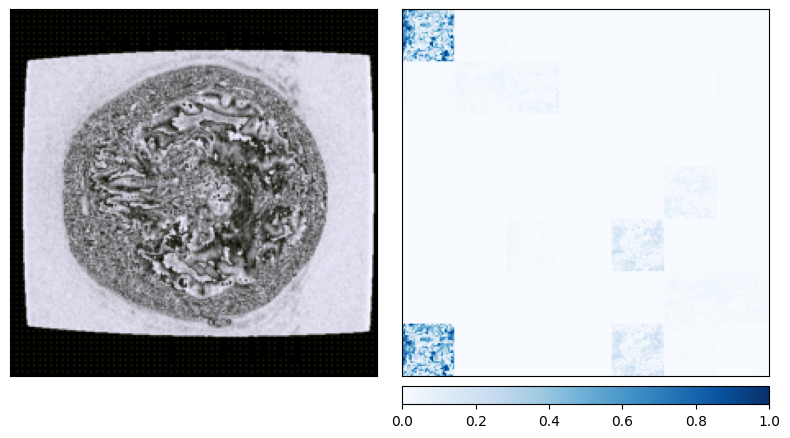


Class: meningioma, Probability: 0.5010555386543274


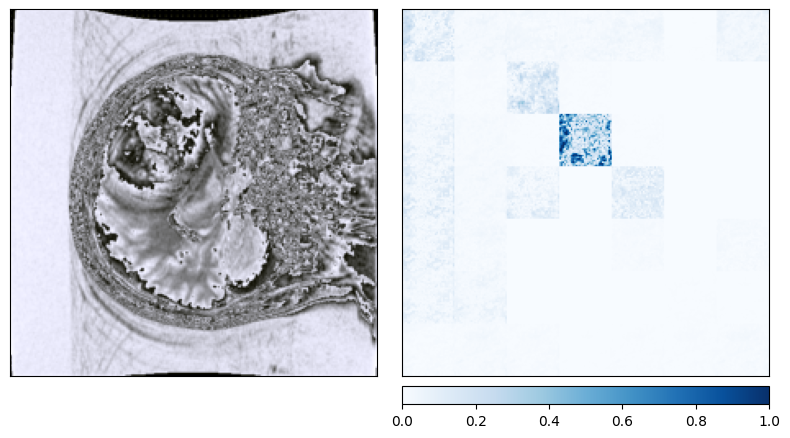


Class: glioma, Probability: 0.6478825807571411


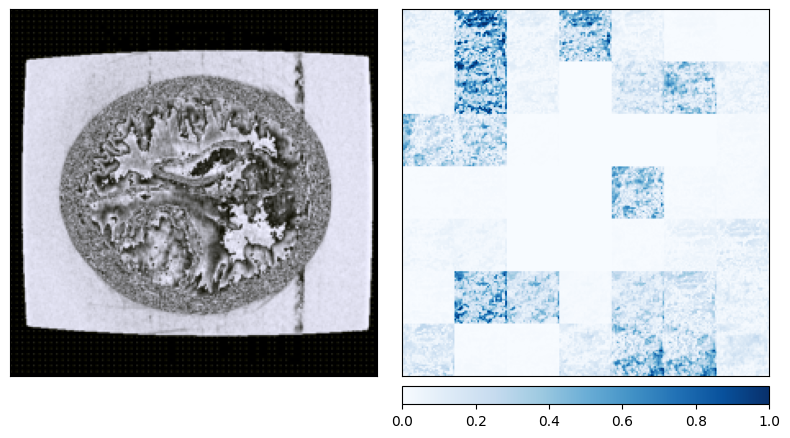


Class: glioma, Probability: 0.7485973238945007


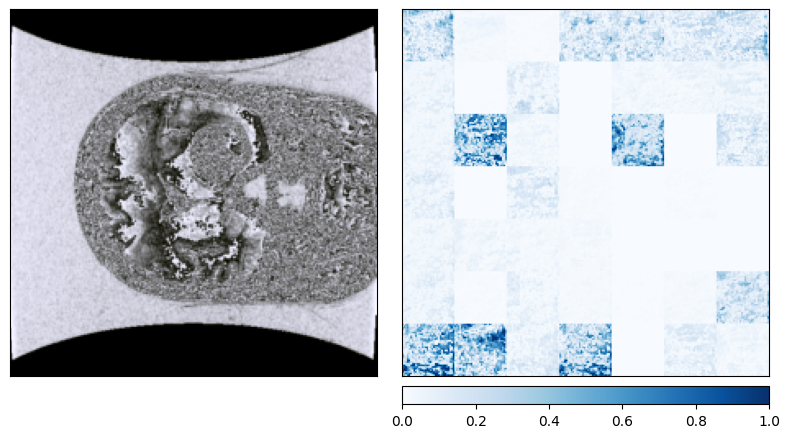


Class: glioma, Probability: 0.7393720746040344


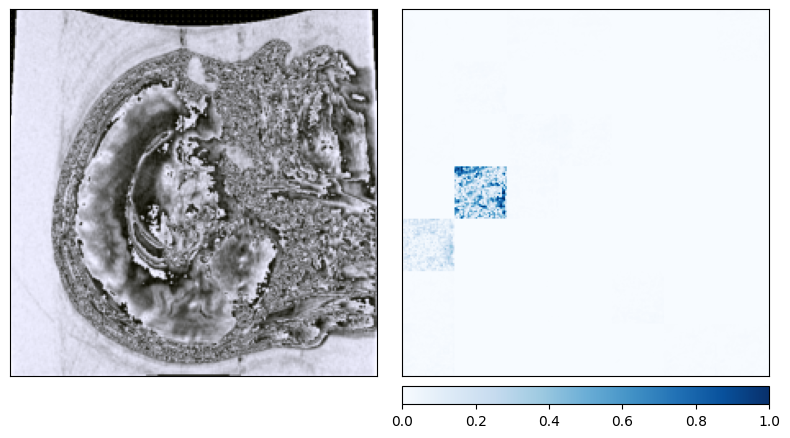


Class: pituitary tumor, Probability: 0.9046853184700012


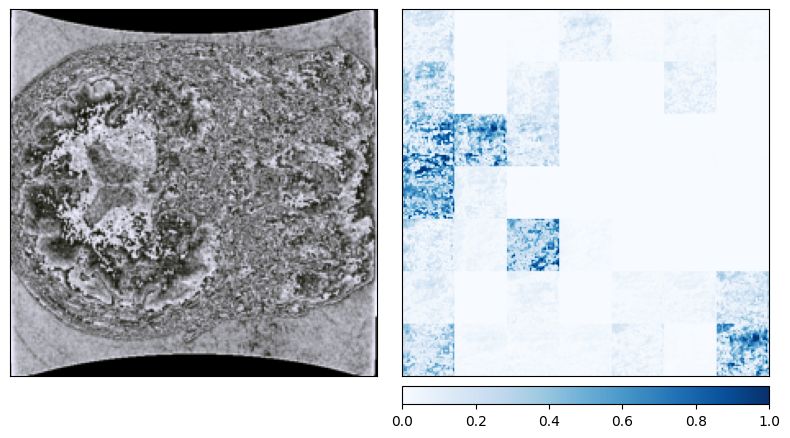


Class: pituitary tumor, Probability: 0.8954586386680603


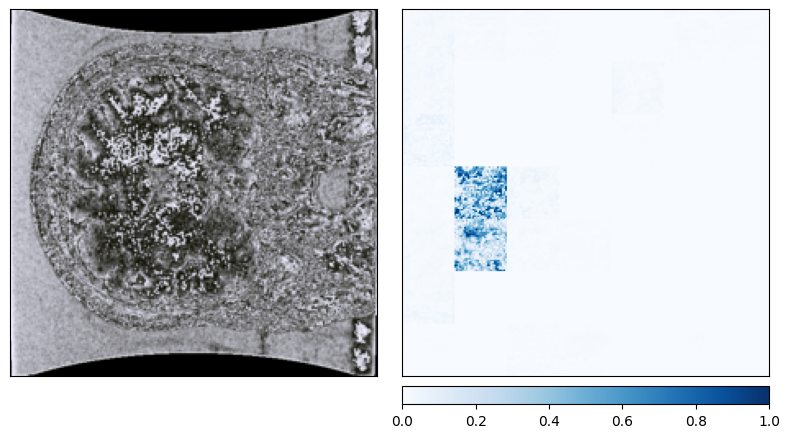


Class: glioma, Probability: 0.8248317241668701


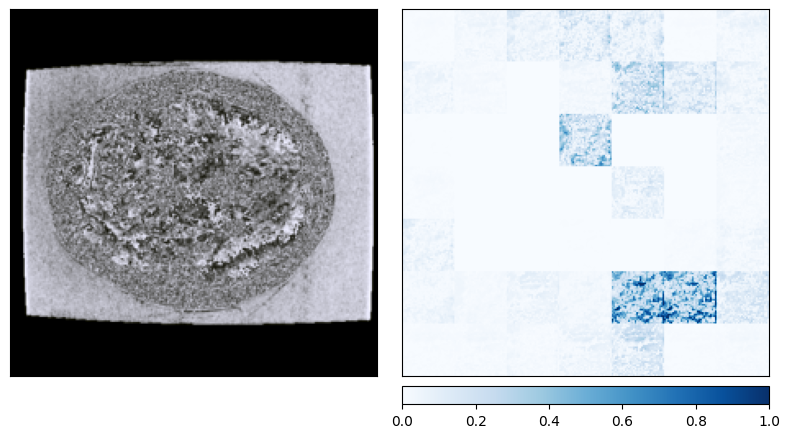


Class: meningioma, Probability: 0.6081739068031311


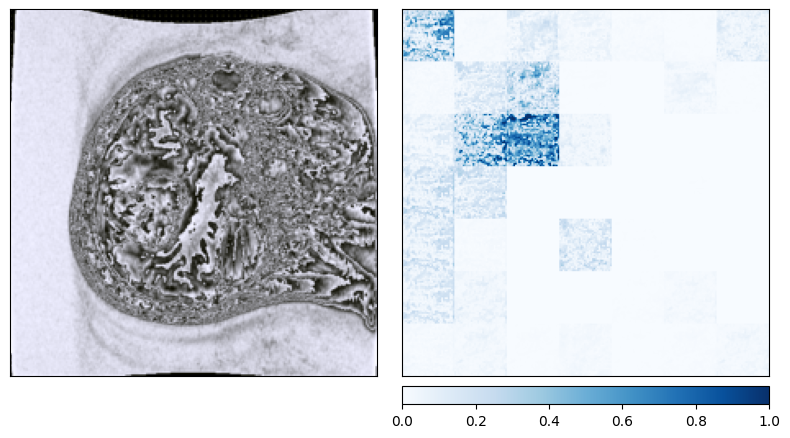


Class: pituitary tumor, Probability: 0.7797049880027771


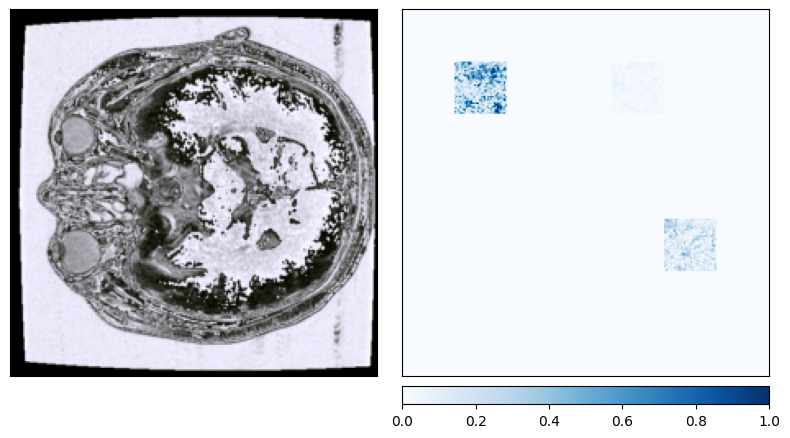

In [45]:
#10 random images
images = ['tumor_data/train/1247.mat', 'tumor_data/train/274.mat','tumor_data/train/725.mat', 'tumor_data/train/910.mat', 'tumor_data/train/171.mat',
          'tumor_data/train/2312.mat', 'tumor_data/train/864.mat', 'tumor_data/test/1098.mat',
          'tumor_data/test/1593.mat', 'tumor_data/validate/2388.mat', 'tumor_data/validate/512.mat', 'tumor_data/validate/992.mat']

# Open the .mat file using h5py
for i, image_path in enumerate(images):

  with h5py.File(image_path, 'r') as file:
    label = file['cjdata']['label'][()][0, 0]
    image_data = file['cjdata']['image'][()]

  array = preprocess(image_data).to(device)

  with torch.no_grad():
    vector = new_vit(array[None, :, :, :].cuda())
  index = decode_brain_preds(vector)

  saliency = captum.attr.Saliency(new_vit)
  image = array.unsqueeze_(0)
  attributions = saliency.attribute(image, target=index)

  # Your input image to the model.
  unnorm_image = inv_normalize(image)

  # Display the image and the attribution
  _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(unnorm_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=None,
                                      show_colorbar=True, outlier_perc=2)